# Amazon

In this example, we VerticaPy with the 'Amazon' dataset to predict the number of forest fires in Brazil. You can download a copy of the Jupyter Notebook of the study <a href="amazon.ipynb">here</a>.
<ul class="ul_content">
    <li><b>date: </b>Date of the record</li>
    <li><b>number: </b>Number of forest fires</li>
    <li><b>state: </b>State in Brazil</li>
</ul>
We will follow the data science cycle (Data Exploration - Data Preparation - Data Modeling - Model Evaluation - Model Deployment) to solve this problem.

## Initialization

Let's create a Virtual DataFrame of the dataset.

In [1]:
from verticapy import *
import verticapy.stats as st
new_auto_connection({"host": "34.237.154.116", 
                     "port": "5433", 
                     "database": "testdrive", 
                     "password": "password", 
                     "user": "dbadmin"},
                    name = "VerticaDSN")
# Set the primary auto-connection
change_auto_connection("VerticaDSN")

In [2]:
amazon = vDataFrame('amazon')

In [ ]:
read_csv('amazon.csv', schema = 'public', table_name = 'amazon')

## Data Exploration and Preparation

We can explore our data by displaying descriptive statistics of all the columns.

,dtype,unique,count,top,top_percent
"""number""",int,1475,6454,0,9.56
"""date""",date,239,6454,2017-01-01,0.434
"""state""",varchar(32),23,6454,Rio,11.109

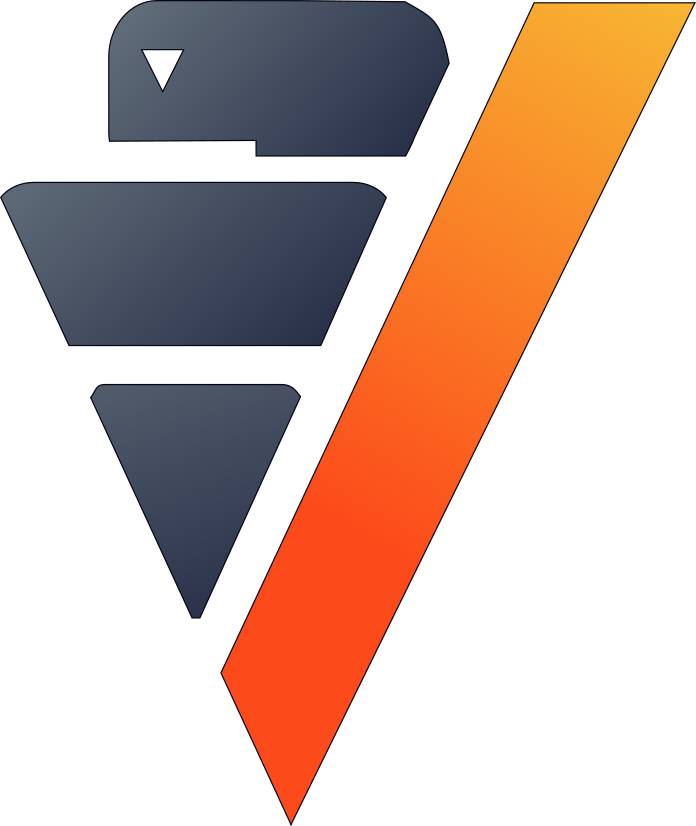

In [3]:
amazon.describe(method = "categorical")

Data are available from 1998 to the end of 2017.

,value
name,"""date"""
dtype,date
count,6454
min,1998-01-01
max,2017-11-01

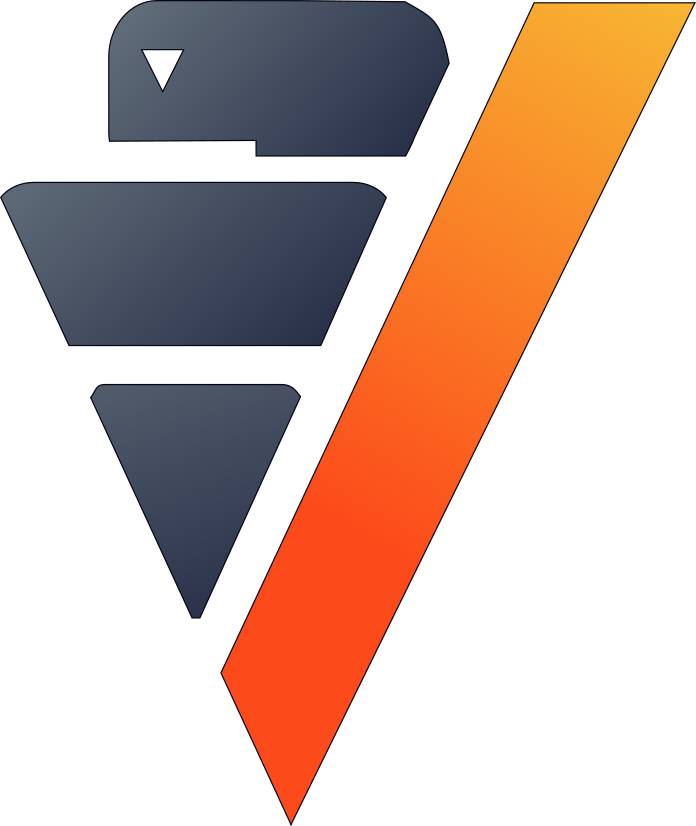

In [4]:
amazon["date"].describe()

Brazil has dry and rainy seasons, so the number of forest fires should vary by season. Let's confirm this using an autocorrelation plot with 48 lags (4 years).

,value,confidence
0,1.0,0.024396841824873755
1,0.531,0.03304773812790809
2,0.352,0.037823405347589246
3,0.21,0.042031387630226874
4,0.079,0.04562464810393294
5,0.021,0.04866179982410025
6,-0.031,0.051453460445325866
7,-0.019,0.05358451912221112
8,0.018,0.05557933150581347
9,0.084,0.05689678494526535

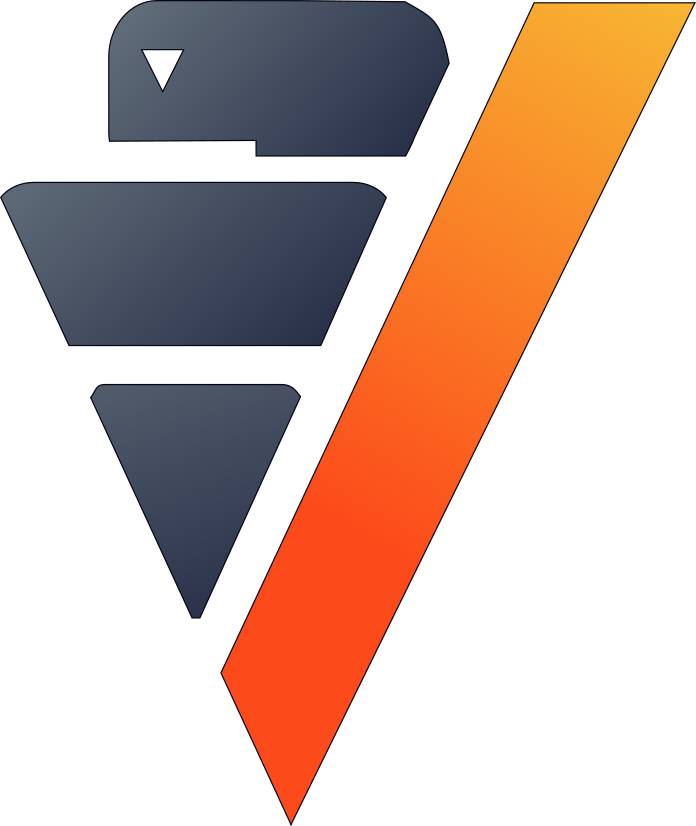

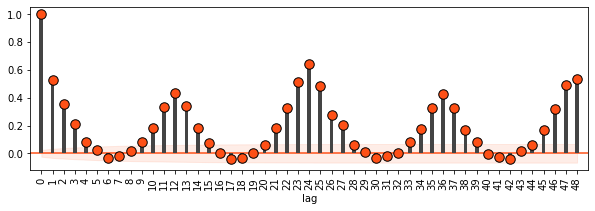

In [5]:
%matplotlib inline
amazon.acf(column = "number", 
           ts = "date",
           by = ["state"],
           p = 48)

The effects of each season seem pretty clear. We can see this graphically using the cumulative sum of the number of forest fires partitioned by states. If our hypothesis is correct, we should see staircase functions.

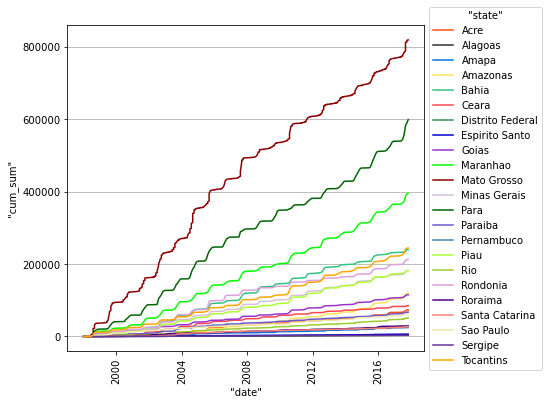

In [6]:
amazon.cumsum("number", 
              by = ["state"], 
              order_by = ["date"], 
              name = "cum_sum")
amazon["cum_sum"].plot(ts = "date", 
                       by = "state")

We can clearly see the seasonality per state which leads to a global seasonality. Let's draw the cumulative sum to see more clearly the phenomenon.

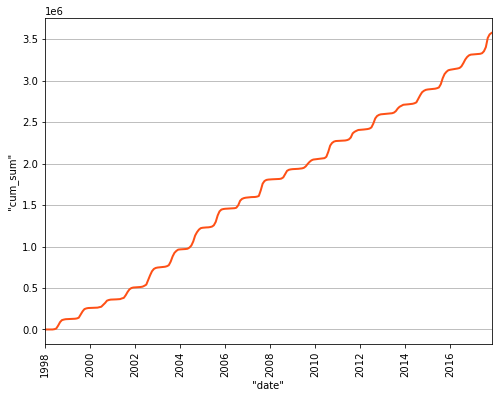

In [7]:
amazon = amazon.groupby(["date"], 
                        [st.sum(amazon["number"])._as("number")])
amazon.cumsum("number", 
              order_by = ["date"], 
              name = "cum_sum")
amazon["cum_sum"].plot(ts = "date")

Let's create an SAR(p) model to predict the number of forest fires in Brazil.

## Machine Learning

Let's create an AR model to predict the number of forest fires in Brazil. We know that this seasonality happens each year (s=12) and let's consider 4 lags (P=4).

c:\users\psingh5\appdata\local\programs\python\python38-32\lib\site-packages\verticapy\toolbox.py:593: Warning: The VerticaPy schema doesn't exist or is incomplete. The model can not be stored.
Please use create_verticapy_schema function to set up the schema and the drop function to drop it if it is corrupted.
  warnings.warn(warning_message, Warning)


,value
explained_variance,0.732488522416225
max_error,51895.523525632605339
median_absolute_error,2282.16597852541
mean_absolute_error,5698.57886703884
mean_squared_error,96698237.9642302
root_mean_squared_error,9833.526222278058
r2,0.760622453388105
r2_adj,0.7565305295143974
aic,4404.775782251333
bic,4421.9005892813775

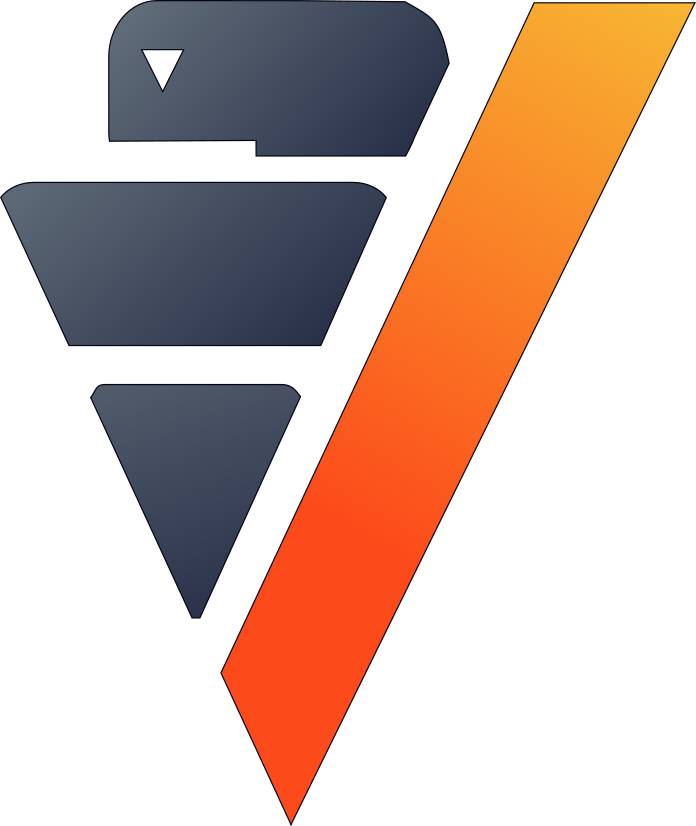

In [8]:
from verticapy.learn.tsa import SARIMAX

model = SARIMAX("amazon_ar", 
                s = 12, 
                P = 4)
model.drop()
model.fit(amazon,
          y = "number",
          ts = "date")
model.regression_report()

Our model is quite good. Let's look at our predictions.

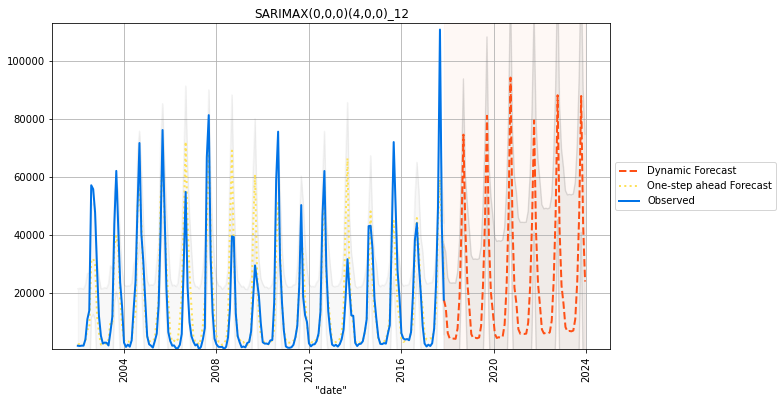

In [17]:
x = model.plot(amazon, 
               nlead=72, 
               dynamic=True)

We can clearly see that our model caught the seasonality. Let's add the prediction in the vDataFrame.

,📅dateDate,123cum_sumInt,"123predictionNumeric(33,15)",123numberInt
1,1998-01-01,0,[null],0
2,1998-02-01,0,[null],0
3,1998-03-01,0,[null],0
4,1998-04-01,0,[null],0
5,1998-05-01,0,[null],0
6,1998-06-01,3551,[null],3551
7,1998-07-01,11617,[null],8066
8,1998-08-01,47166,[null],35549
9,1998-09-01,89134,[null],41968
10,1998-10-01,112629,[null],23495

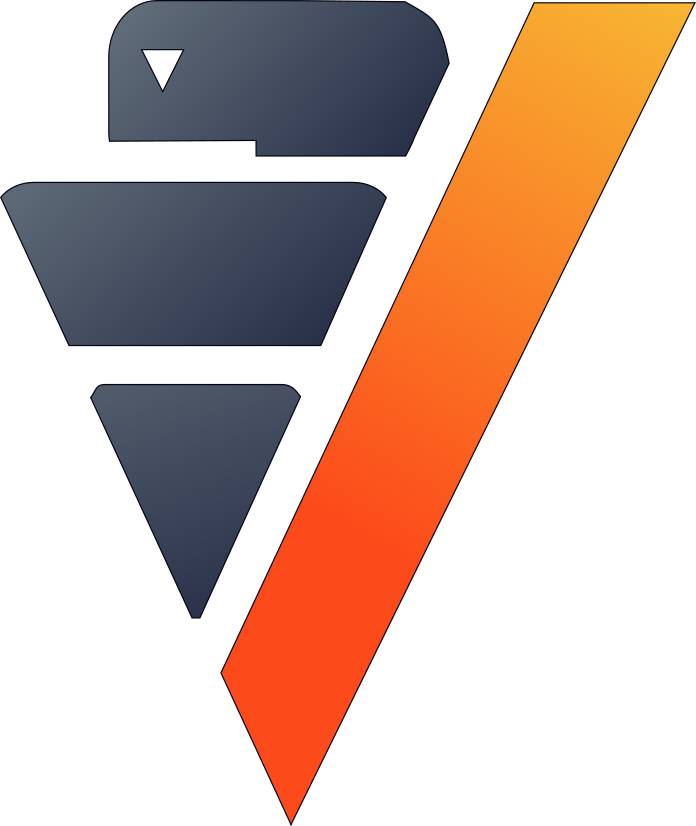

In [10]:
amazon = model.predict(amazon, name = "prediction")
display(amazon)

We can easily compare the prediction with the real value using a TS Plot.

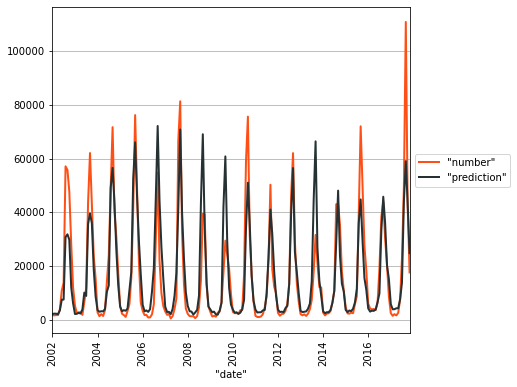

In [11]:
amazon.plot(ts = "date", 
            columns = ["number", "prediction"])

Our prediction seems to follow the trend! We can also look at the distribution of the real values and the predictions.

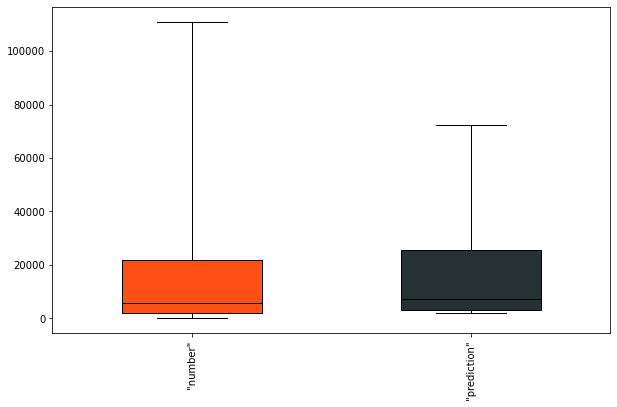

In [12]:
amazon.boxplot(columns = ["number", "prediction"])

Barring the really unpredictable events, our predictions seem to match up quite closely.

## Conclusion

We've solved our problem in a Pandas-like way, all without ever loading data into memory!